# Camera Calibration

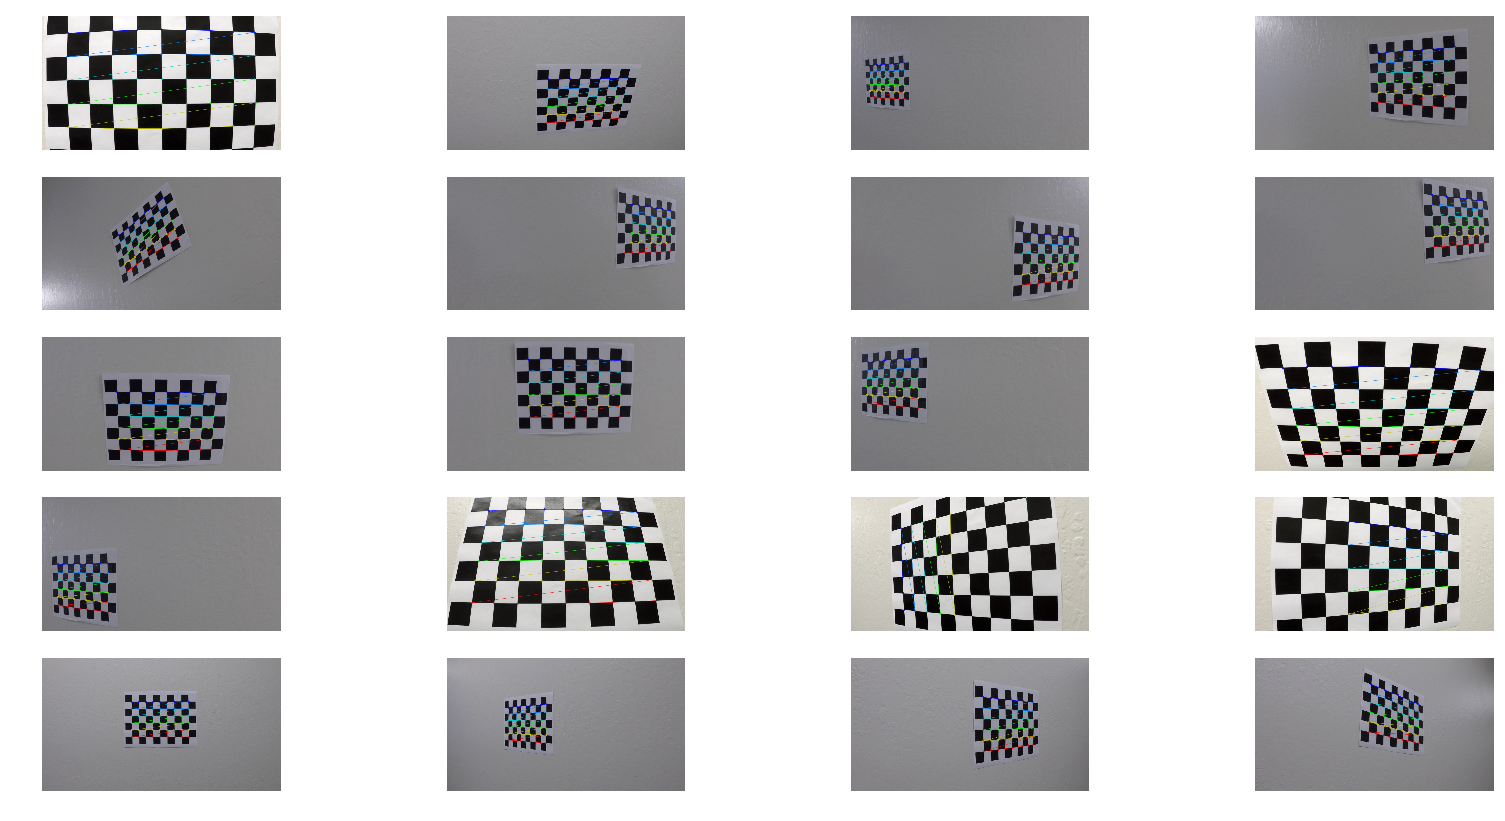

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
def get_object_points(size):
    objp = np.zeros((size[0]*size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:size[0],0:size[1]].T.reshape(-1,2)
    return objp

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# prepare pattern size
pattern_sizes = [(9,6),(9,5),(6,5),(7,5)]

# Step through the list and search for chessboard corners
i = 1
plt.figure(figsize=(20, 10))
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    for size in pattern_sizes:
        ret, corners = cv2.findChessboardCorners(gray, size, None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(get_object_points(size))
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, size, corners, ret)
            plt.subplot(5, 4, i)
            plt.axis('off')
            plt.imshow(img)
            i+=1
            break

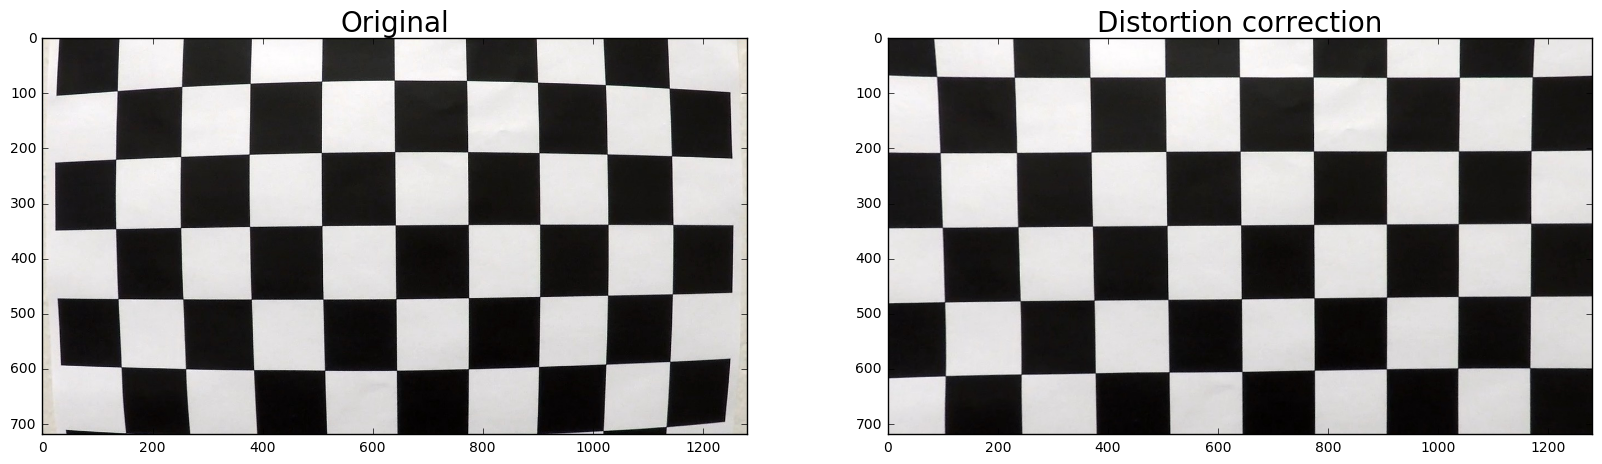

In [2]:
# Test image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Distortion correction', fontsize=20)

In [3]:
# Save the matrix and distortion coefficients
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_dist_pickle.p", "wb"))

# Image Pipeline

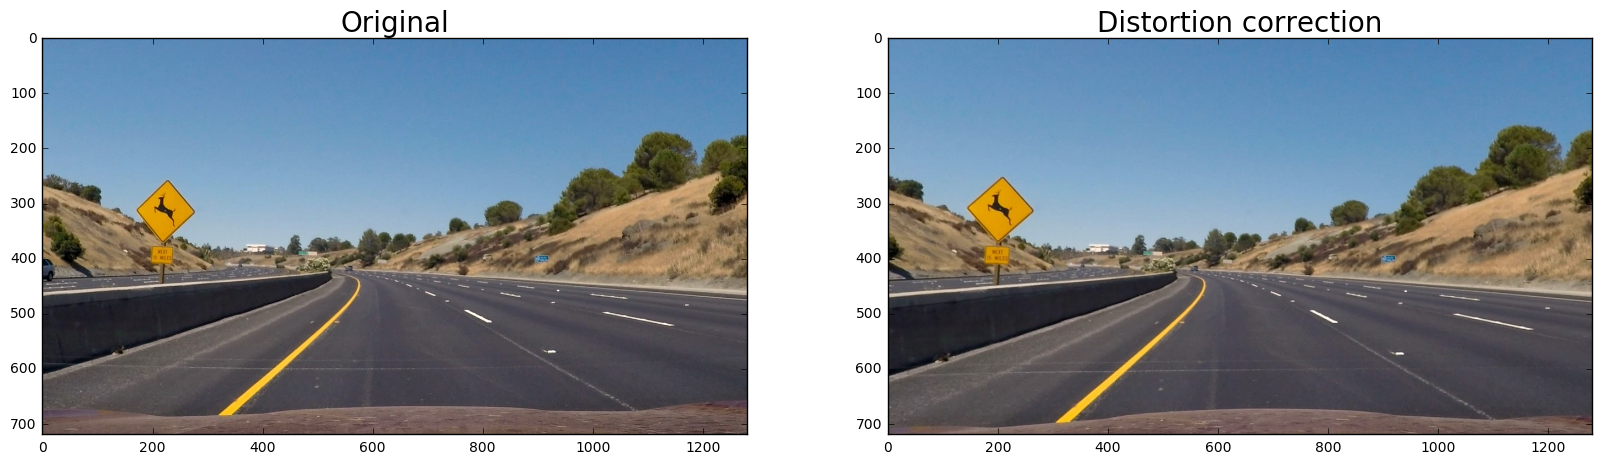

In [9]:
# Undistortion Test
test_img = mpimg.imread('test_images/test1.jpg')
undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist_img)
ax2.set_title('Distortion correction', fontsize=20)

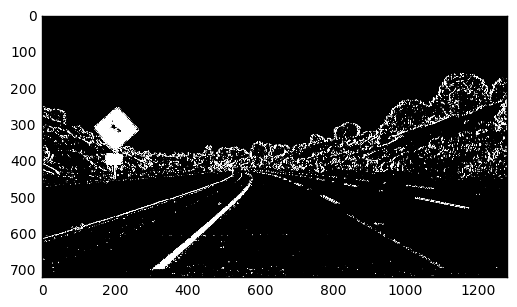

In [10]:
def thresholding(img, sx_thresh=(20, 100), s_thresh=(170, 255)):
    # Convert to HLS color space and separate channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

plt.imshow(thresholding(undist_img), cmap='gray')

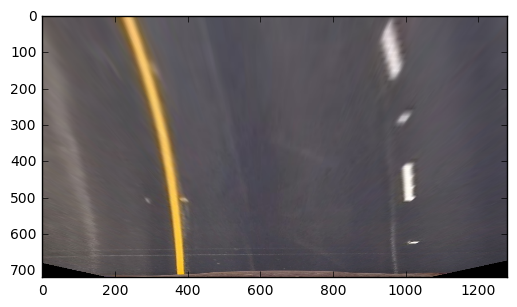

In [11]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[586,460],[203,720],[1127,720],[695,460]])
    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plt.imshow(warp(undist_img))